In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
starts = pd.read_csv('starts_q.csv')

In [16]:
starts.index = pd.period_range(start='1980',end='2020-12',freq='q')
starts =starts.drop(columns=['_date_'])

<AxesSubplot:>

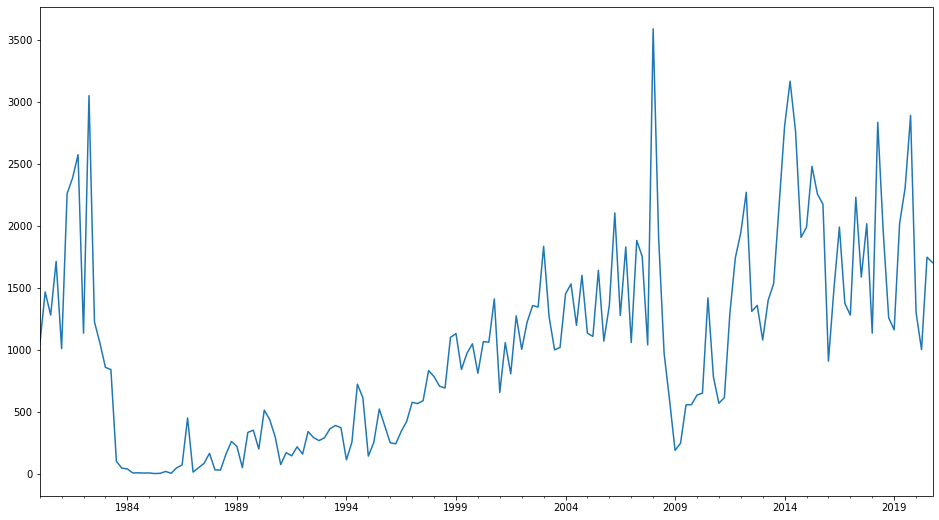

In [4]:
starts['multi_start'].plot(figsize=(16,9))

<AxesSubplot:>

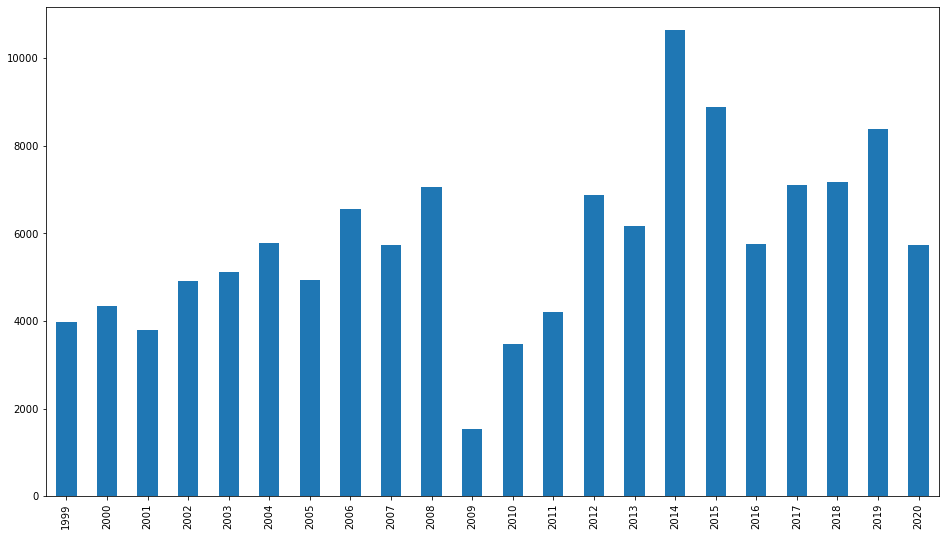

In [91]:
starts['multi_start'].resample('A').sum()['1999':].plot(figsize=(16,9),kind='bar')

<AxesSubplot:>

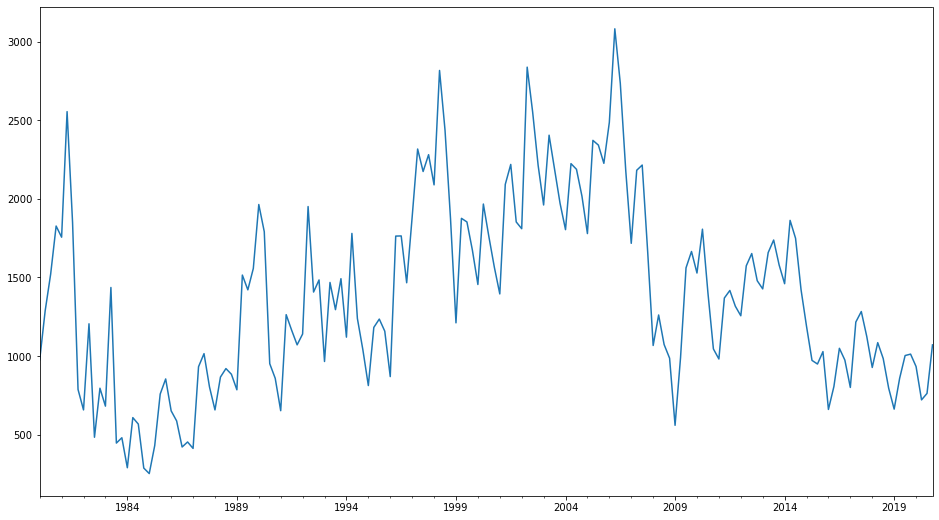

In [5]:
starts['sfd_start'].plot(figsize=(16,9))

<AxesSubplot:>

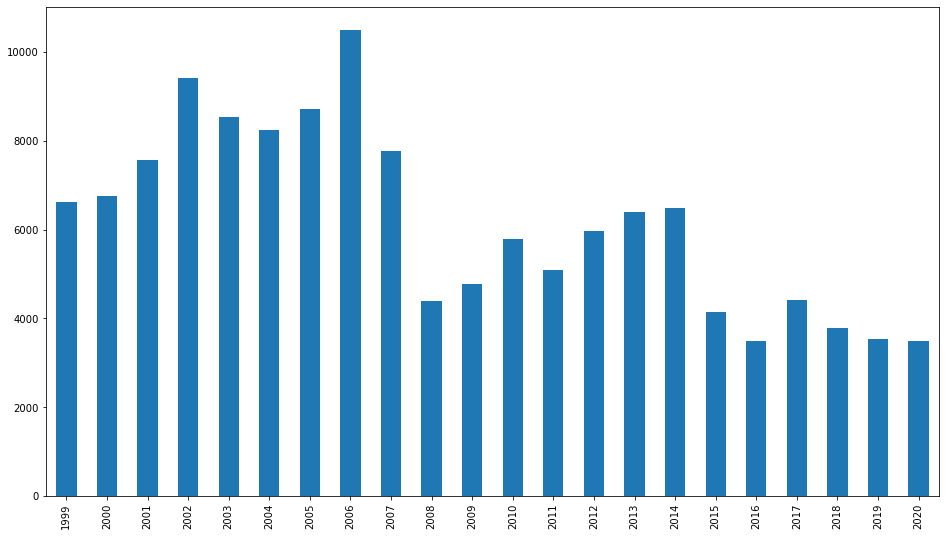

In [92]:
starts['sfd_start'].resample('A').sum()['1999':].plot(figsize=(16,9),kind='bar')

In [93]:
starts['sfd_start'].resample('A').sum()['1999':]

1999     6613.0
2000     6749.0
2001     7559.0
2002     9413.0
2003     8526.0
2004     8233.0
2005     8719.0
2006    10482.0
2007     7777.0
2008     4387.0
2009     4775.0
2010     5782.0
2011     5084.0
2012     5961.0
2013     6402.0
2014     6494.0
2015     4138.0
2016     3489.0
2017     4423.0
2018     3791.0
2019     3535.0
2020     3487.0
Freq: A-DEC, Name: sfd_start, dtype: float64

In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print('Results of Dickey-Fuller')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test statistic', 'p-val', '# lags', 'N'])
    for key, val in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = val
    print(dfoutput)

In [7]:
adf_test(starts['multi_start'])

Results of Dickey-Fuller
Test statistic           -2.151781
p-val                     0.224209
# lags                    4.000000
N                       159.000000
Critical Value (1%)      -3.472161
Critical Value (5%)      -2.879895
Critical Value (10%)     -2.576557
dtype: float64


In [17]:
starts_diff= starts.diff()
starts_diff = starts_diff.dropna()

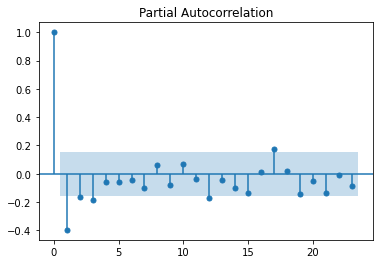

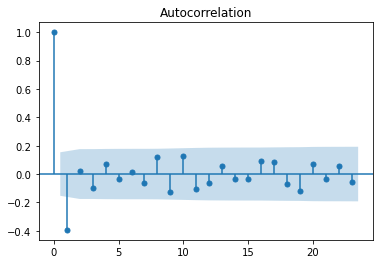

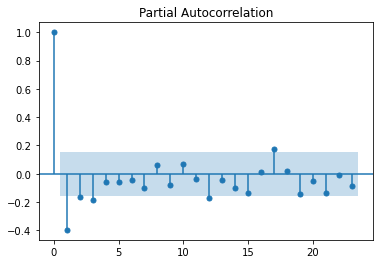

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(starts_diff['multi_start'])
plot_pacf(starts_diff['multi_start'])

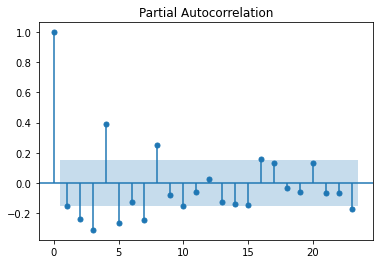

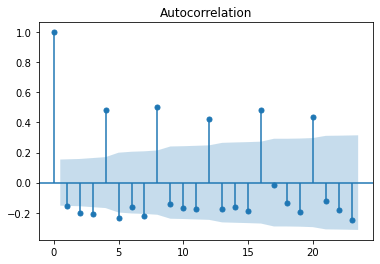

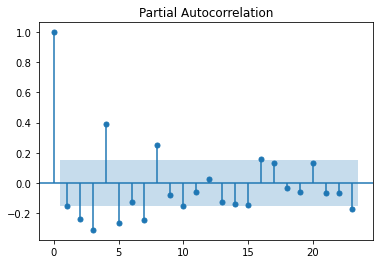

In [19]:
plot_acf(starts_diff['sfd_start'])
plot_pacf(starts_diff['sfd_start'])

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(starts_diff['multi_start'],order=(4,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            multi_start   No. Observations:                  163
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1239.399
Date:                Thu, 18 Feb 2021   AIC                           2492.798
Time:                        17:54:01   BIC                           2514.454
Sample:                    06-30-1980   HQIC                          2501.590
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5278      4.503      1.672      0.095      -1.299      16.354
ar.L1          0.4592      0.069      6.698      0.000       0.325       0.594
ar.L2          0.2085      0.059      3.507      0.0

<AxesSubplot:>

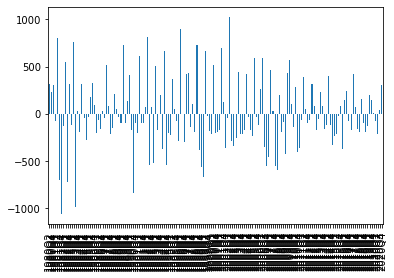

In [25]:
starts_diff['sfd_start'].plot(kind='bar')

<AxesSubplot:xlabel='_date_'>

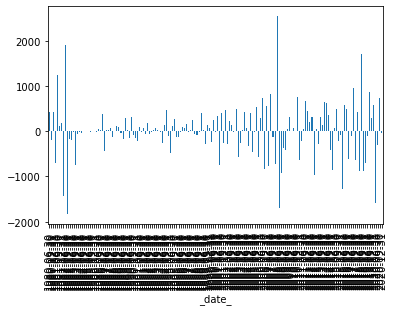

In [28]:
starts_diff['multi_start'].plot(kind='bar')

<AxesSubplot:>

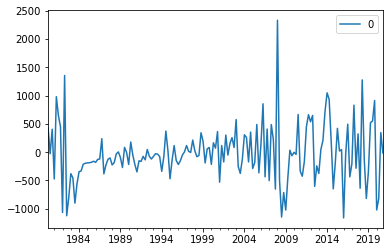

In [26]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(starts_diff['sfd_start'],order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              sfd_start   No. Observations:                  163
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1184.025
Date:                Thu, 18 Feb 2021   AIC                           2376.049
Time:                        18:01:15   BIC                           2388.424
Sample:                    06-30-1980   HQIC                          2381.073
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4469     10.031     -0.144      0.885     -21.106      18.213
ar.L1          0.5929      0.116      5.101      0.000       0.365       0.821
ma.L1         -0.8716      0.070    -12.380      0.0

<AxesSubplot:>

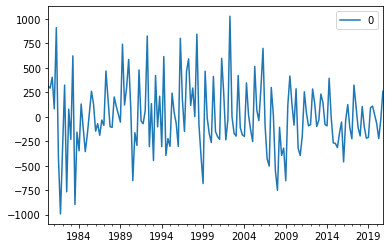

In [28]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [29]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr

    return({'mape':mape, 'mean error':me, 'mae': mae, 
            'mean percentage error': mpe, 'rmse':rmse,
            'corr':corr})

In [30]:
import math
from sklearn.metrics import mean_squared_error

val = starts['sfd_start'].values
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history,order=(1,1,1))
    model_fit=model.fit()
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat,obs))
rmse=math.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' %rmse)

predicted=1691.707235, expected=1422.000000
predicted=1464.546182, expected=1189.000000
predicted=1292.144291, expected=972.000000
predicted=1122.227265, expected=949.000000
predicted=1087.166352, expected=1028.000000
predicted=1128.691939, expected=660.000000
predicted=845.723262, expected=806.000000
predicted=930.508574, expected=1049.000000
predicted=1095.161602, expected=974.000000
predicted=1033.661251, expected=800.000000
predicted=896.955856, expected=1216.000000
predicted=1192.145039, expected=1283.000000
predicted=1245.103816, expected=1124.000000
predicted=1132.329438, expected=927.000000
predicted=987.070177, expected=1085.000000
predicted=1095.134246, expected=984.000000
predicted=1020.081038, expected=795.000000
predicted=877.758780, expected=662.000000
predicted=769.843523, expected=858.000000
predicted=899.424955, expected=1003.000000
predicted=1000.300148, expected=1012.000000
predicted=1007.246838, expected=933.000000
predicted=950.117414, expected=721.000000
predicted

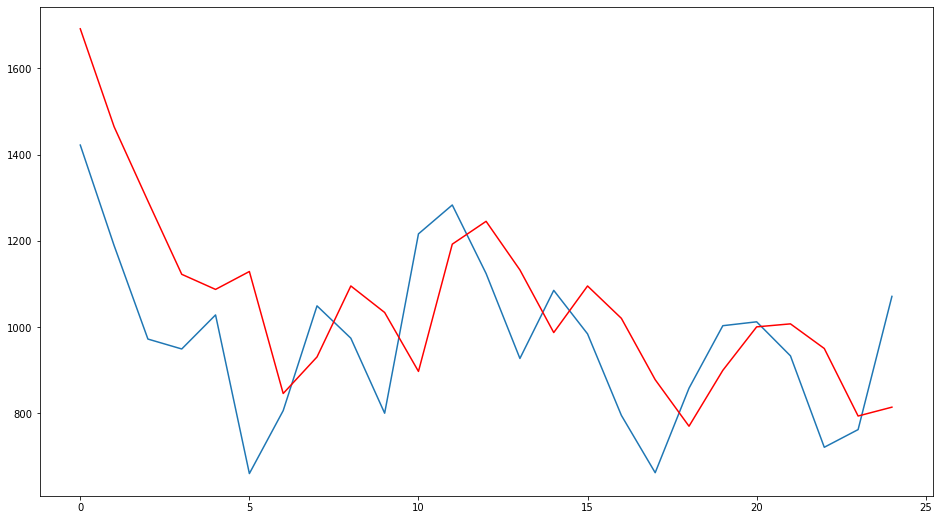

In [31]:
plt.figure(figsize=(16,9))
plt.plot(test,label='test')
plt.plot(predictions,label='predict',color='red')

In [32]:
forecast_accuracy(predictions,test)

{'mape': 0.18602401919332437,
 'mean error': 83.5021184887276,
 'mae': 170.44128714763778,
 'mean percentage error': 0.1065100246377694,
 'rmse': 201.88501848672382,
 'corr': 0.5687260543448193}

In [33]:

val = starts['multi_start'].values
size = int(len(val)*0.85)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history,order=(1,1,1))
    model_fit=model.fit()
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat,obs))
rmse=math.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' %rmse)

predicted=2886.787917, expected=1906.000000
predicted=2339.595394, expected=1988.000000
predicted=2102.239571, expected=2479.000000
predicted=2304.028790, expected=2254.000000
predicted=2287.797007, expected=2174.000000
predicted=2225.432958, expected=907.000000
predicted=1516.671521, expected=1487.000000
predicted=1464.136443, expected=1989.000000
predicted=1772.878947, expected=1373.000000
predicted=1556.592859, expected=1279.000000
predicted=1408.192298, expected=2230.000000
predicted=1845.537508, expected=1586.000000
predicted=1706.214086, expected=2016.000000
predicted=1866.893606, expected=1133.000000
predicted=1495.010894, expected=2834.000000
predicted=2119.756517, expected=1956.000000
predicted=2108.577509, expected=1257.000000
predicted=1676.441150, expected=1160.000000
predicted=1417.474291, expected=2020.000000
predicted=1718.802241, expected=2304.000000
predicted=1999.320514, expected=2890.000000
predicted=2433.358266, expected=1299.000000
predicted=1830.392362, expected=1

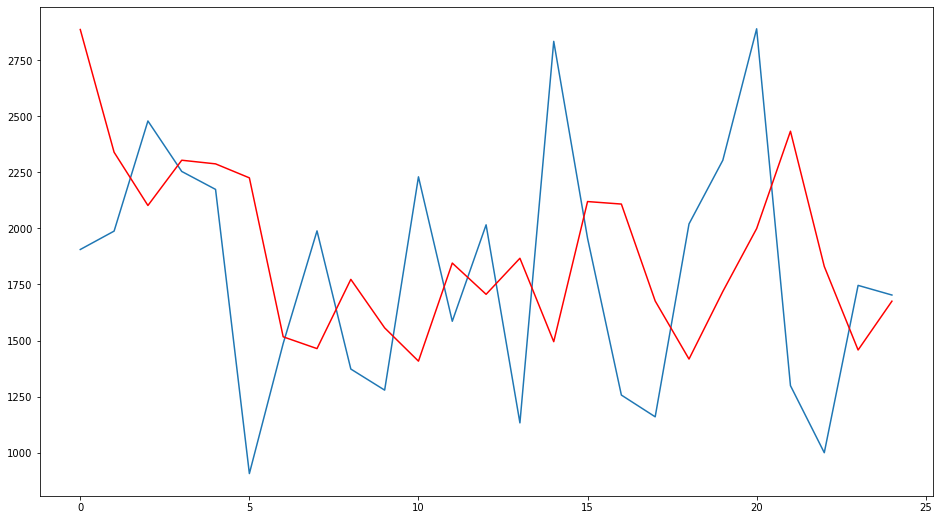

In [34]:
plt.figure(figsize=(16,9))
plt.plot(test,label='test')
plt.plot(predictions,label='predict',color='red')

In [44]:
forecast_accuracy(predictions,test)

{'mape': 0.35685571280677514,
 'mean error': 89.82241584326343,
 'mae': 551.1169690069974,
 'mean percentage error': 0.1606855170583055,
 'rmse': 670.5919026389018,
 'corr': -0.03929632651096101}

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
prov_fcast = pd.read_csv('prov_forecasts.csv')
nat_fcast = pd.read_csv('nat_forecast.csv')
prov_fcast=prov_fcast.set_index('Unnamed: 0')
nat_fcast=nat_fcast.set_index('date')


In [37]:
nat_exog = nat_fcast[['Interest rate on fixed 5-year mortgages [%]','World Price Oil (West Texas Intermediate)']]
nat_exog=nat_exog.rename(columns={
    'Interest rate on fixed 5-year mortgages [%]':'morg_rate',
    'World Price Oil (West Texas Intermediate)':'wti'
})
nat_exog=nat_exog[:'2024']
comm_fcast =pd.read_csv('comm_fore.csv')
nat_exog.wti[164:] = comm_fcast[116:].WTI

In [38]:
nat_exog.index = pd.period_range(start='1980',end='2023-12',freq='q')

In [39]:
prov_fcast

,Alberta_Real GDP,Alberta_Real household disp. income,Alberta_CPI,Alberta_Unemployment rate,Alberta_Number of households,Alberta_Share of population aged 25-34,Alberta_Real 5-year mortgage rate
Unnamed: 0,,,,,,,
1984Q1,123554.787000,43487.392479,0.593435,10.900000,8.036833e+05,0.202737,9.197292
1984Q2,126137.482000,44638.104602,0.595181,11.600000,8.052995e+05,0.202876,12.055714
1984Q3,125411.117000,44106.463796,0.600481,11.733333,8.067957e+05,0.202639,11.631155
1984Q4,129204.614000,44773.150681,0.603223,11.400000,8.083714e+05,0.203535,10.734994
1985Q1,135372.716000,46578.003995,0.608993,10.466667,8.102094e+05,0.204120,10.332823
...,...,...,...,...,...,...,...
2023Q4,363862.101939,131206.810400,1.415650,9.347530,1.785216e+06,0.145693,-1.464258
2024Q1,369741.211128,132074.703219,1.424879,9.083781,1.794615e+06,0.145249,-1.745479
2024Q2,375038.059258,133023.757237,1.433453,8.898994,1.803920e+06,0.144720,-1.286832


In [40]:
sales = pd.read_csv('sales_fcast.csv',index_col=0)
sales = sales.rename(columns={'0':'sales'})
sales.index = pd.period_range(start='1980',end = '2023-12', freq='q')

<AxesSubplot:>

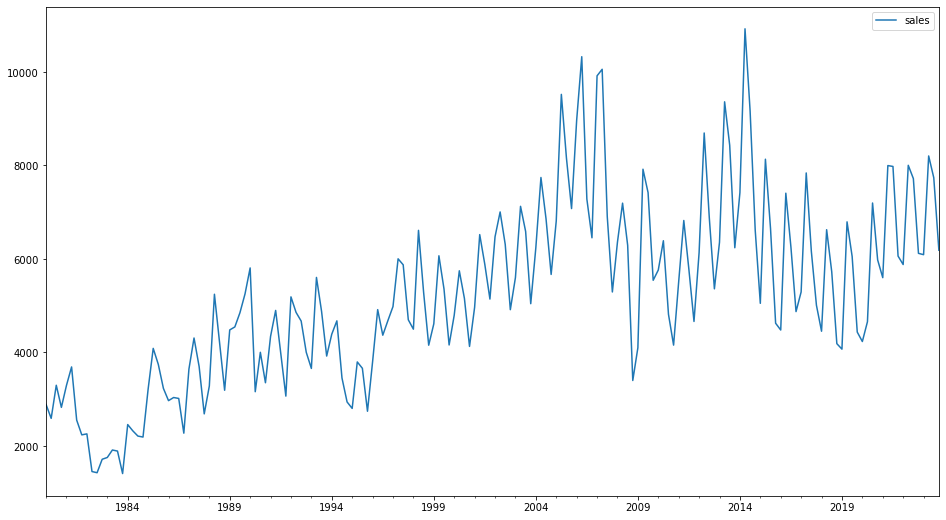

In [41]:
sales.plot(figsize=(16,9))

In [42]:
prices = pd.read_csv('prices_fcast.csv',index_col=0)
prices = prices.rename(columns={'0':'avg_price'})
prices.index = pd.period_range(start='1980',end = '2023-12', freq='q')

RMSE: 514.185


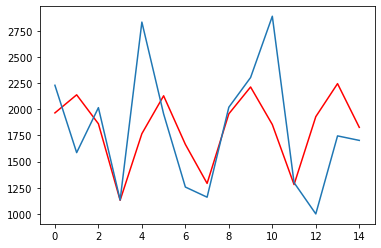

In [43]:
val = starts['multi_start']['1984':].values
size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = sales['1984':'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,0,4))
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

RMSE: 506.917


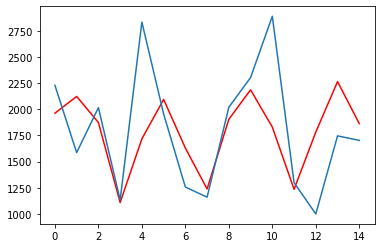

In [44]:
val = starts['multi_start']['1984':].values
size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = sales['1984':'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,0,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [45]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 4)   Log Likelihood                -974.919
Date:                            Thu, 18 Feb 2021   AIC                           1959.837
Time:                                    19:33:18   BIC                           1974.097
Sample:                                         0   HQIC                          1965.631
                                            - 133                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0437      0.028      1.587      0.113      -0.010       0.098
ar.L1          0.4716      0.053      8.966      0.000       0.368       0.575
ma.L1         -1.0000      0.066    -15.216      0.000      -1.129      -0.871
ar.S.L4       -0.5631      0.036    -15.706      0.000      -0.633      -0.493
sigma2       2.32e+05   2.83e-07   8.19e+11      0.000    2.32e+05    2.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               260.07
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              21.88   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.1e+26. Standard errors may be unstable.
"""

RMSE: 274.090


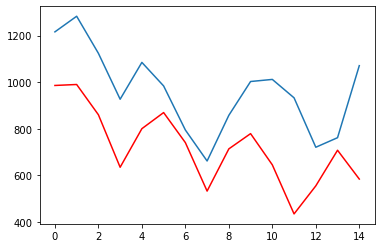

In [46]:
val = starts['sfd_start']['1984':].values
size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = sales['1984':'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,1,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)

plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -890.159
Date:                           Thu, 18 Feb 2021   AIC                           1792.319
Time:                                   19:33:22   BIC                           1809.431
Sample:                                        0   HQIC                          1799.271
                                           - 133                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0260      0.024      1.066      0.287      -0.022       0.074
ar.L1         -0.9520      0.166     -5.731      0.000      -1.278      -0.626
ma.L1          0.9316      0.194      4.798      0.000       0.551       1.312
ar.S.L4       -0.1945      0.112     -1.734      0.083      -0.414       0.025
ma.S.L4       -0.7358      0.110     -6.690      0.000      -0.951      -0.520
sigma2      6.241e+04   6540.383      9.542      0.000    4.96e+04    7.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):                 6.39
Prob(Q):                              0.31   Prob(JB):                         0.04
Heteroskedasticity (H):               0.83   Skew:                            -0.09
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
prov_fcast.index = pd.period_range(start='1984',end = '2024-12',freq='q')
exog_var = nat_exog['1984':]
exog_var=exog_var.join(prov_fcast)
exog_var = exog_var.join(sales['1984':])


In [49]:
exog_var=exog_var.join(prices['1984':])

In [50]:
exog_var['avg_price']=np.log(exog_var['avg_price'])

RMSE: 528.480


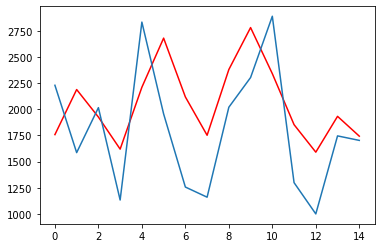

In [51]:
val = starts['multi_start']['1984':].values

variables = ['Alberta_Unemployment rate','Alberta_Share of population aged 25-34','wti','sales']

size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = exog_var[variables][:'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,0,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

RMSE: 284.935
C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


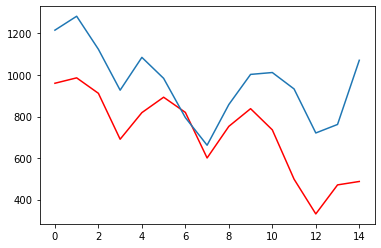

In [52]:
val = starts['sfd_start']['1984':].values

variables = ['Alberta_Number of households','Alberta_Real 5-year mortgage rate','Alberta_Unemployment rate','sales']

size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = exog_var[variables][:'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
out_fcast = output.summary_frame(alpha=0.7)

plt.plot(output.summary_frame()['mean'],color='red')
plt.plot(test)

In [53]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  133
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -897.527
Date:                             Thu, 18 Feb 2021   AIC                           1815.054
Time:                                     19:33:34   BIC                           1843.574
Sample:                                          0   HQIC                          1826.642
                                             - 133                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008      0.013      0.063      0.950      -0.024       0.026
x2            11.8930     47.007      0.253      0.800     -80.239     104.025
x3           -23.7299     99.454     -0.239      0.811    -218.657     171.197
x4             0.0377      0.054      0.701      0.483      -0.068       0.143
ar.L1          0.7991      0.341      2.342      0.019       0.130       1.468
ma.L1         -0.7579      0.347     -2.187      0.029      -1.437      -0.079
ma.L2         -0.1579      0.176     -0.896      0.370      -0.503       0.188
ar.S.L4       -0.1704      0.256     -0.666      0.506      -0.672       0.331
ma.S.L4       -0.6574      0.232     -2.836      0.005      -1.112      -0.203
sigma2      1.135e+05   2.27e+04      4.995      0.000    6.89e+04    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.38
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.76   Skew:                             0.03
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

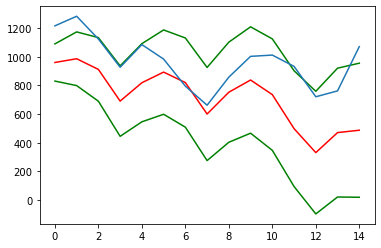

In [54]:
plt.plot(out_fcast['mean'],color='red')
plt.plot(out_fcast['mean_ci_lower'],color='green')
plt.plot(out_fcast['mean_ci_upper'],color='green')

plt.plot(test)

RMSE: 568.888
C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


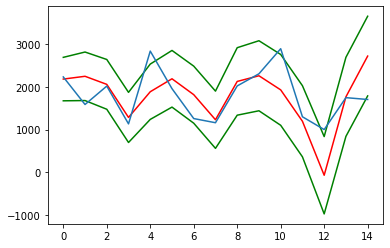

In [55]:
val = starts['multi_start']['1984Q2':].values

variables = ['Alberta_Unemployment rate','Alberta_Share of population aged 25-34','wti','sales']



size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = exog_var[variables][:'2020'].diff().dropna().values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,0,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
out_fcast = output.summary_frame(alpha=0.3)

plt.plot(out_fcast['mean'],color='red')
plt.plot(out_fcast['mean_ci_lower'],color='green')
plt.plot(out_fcast['mean_ci_upper'],color='green')

plt.plot(test)


RMSE: 588.372
C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


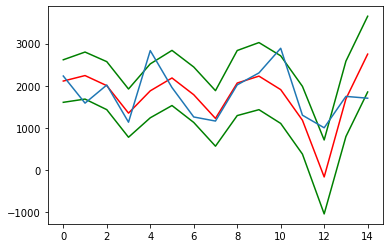

In [59]:
val = starts['multi_start']['1984Q2':].values

variables = ['wti','Alberta_Unemployment rate','sales']



size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = exog_var[variables][:'2020'].diff().dropna().values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,1), seasonal_order=(1,1,0,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
out_fcast = output.summary_frame(alpha=0.3)

plt.plot(out_fcast['mean'],color='red')
plt.plot(out_fcast['mean_ci_lower'],color='green')
plt.plot(out_fcast['mean_ci_upper'],color='green')

plt.plot(test)


In [60]:
forecast_accuracy(out_fcast['mean'],test)

{'mape': 0.25971116737686806,
 'mean error': -47.6856140251393,
 'mae': 418.39540698218286,
 'mean percentage error': -0.015614655897283392,
 'rmse': 588.372261414915,
 'corr': 0.5504832390590637}

RMSE: 341.422
C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


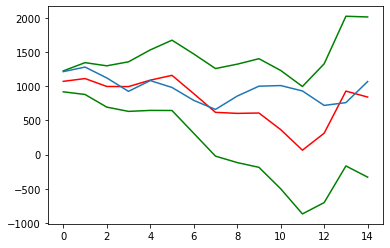

In [61]:
val = starts['sfd_start']['1984':].values

variables = ['Alberta_Number of households','Alberta_Real 5-year mortgage rate','Alberta_Unemployment rate','sales','avg_price']

size = int(len(val)*0.9)
train, test = val[0:size], val[size:len(val)]
history=[x for x in train]
exog = exog_var[variables][:'2020'].values
exog_train, exog_test = exog[0:size], exog[size:len(exog)]
predictions = list()
model = SARIMAX(history,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog_train)
model_fit=model.fit()
output=model_fit.get_forecast(len(test), exog=exog_test)
rmse=math.sqrt(mean_squared_error(test,output.summary_frame()['mean']))
print('RMSE: %.3f' % rmse)
out_fcast = output.summary_frame(alpha=0.6)

plt.plot(out_fcast['mean'],color='red')
plt.plot(out_fcast['mean_ci_lower'],color='green')
plt.plot(out_fcast['mean_ci_upper'],color='green')

plt.plot(test)

C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


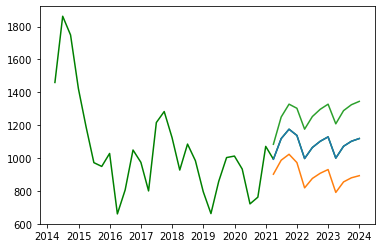

In [62]:
val = starts['sfd_start']['1984':].values
variables = ['wti','Alberta_Real 5-year mortgage rate','sales']

exog = exog_var[variables][:'2020'].values
exog_fcast = exog_var[variables][160-12:160]

model = SARIMAX(val,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2021',periods=12,freq='q')

history = starts['sfd_start']['2014':]
history=history.append(fcast_res['mean'])
history.index = pd.date_range(start='2014',end='2024',freq='q')

plt.plot(history,color='green')
his_sfd = history
f_sfd = fcast_res[['mean','mean_ci_lower','mean_ci_upper']]
plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [ ]:
fcast_res.to_csv('sfd_fcast_1.csv')

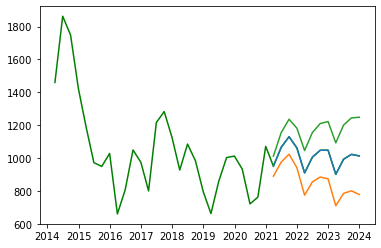

In [85]:
val = starts['sfd_start']['1984':].values
variables = ['wti','Alberta_Real 5-year mortgage rate','sales']

exog = exog_var[variables][:'2020'].values
exog_fcast = exog_var[variables][160-12:160]

model = SARIMAX(val,order=(2,1,0), seasonal_order=(1,1,1,4),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.8)
fcast_res.index= pd.date_range(start='2021',periods=12,freq='q')

history = starts['sfd_start']['2014':]
history=history.append(fcast_res['mean'])
history.index = pd.date_range(start='2014',end='2024',freq='q')

plt.plot(history,color='green')
his_sfd = history
f_sfd = fcast_res[['mean','mean_ci_lower','mean_ci_upper']]
plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [84]:
fcast_res['mean']['2021'].sum()/his_sfd['2020'].sum()

1.2115166518666423

In [243]:
fcast_res.to_csv('sfd_fcast_3.csv')

In [86]:
fcast_res['mean']['2021'].sum()

4206.547176915767

In [239]:
his_sfd['2020'].sum()

3487.0

C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


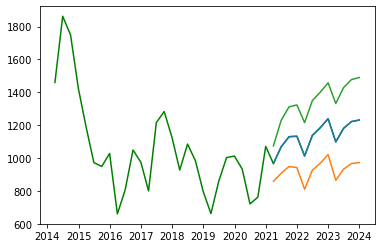

In [64]:
val = starts['sfd_start']['1984':].values
variables = ['wti','Alberta_Real 5-year mortgage rate','Alberta_Unemployment rate','sales']

exog = exog_var[variables][:'2020'].values
exog_fcast = exog_var[variables][160-12:160]

model = SARIMAX(val,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.7)
fcast_res.index= pd.date_range(start='2021',periods=12,freq='q')

history = starts['sfd_start']['2014':]
history=history.append(fcast_res['mean'])
history.index = pd.date_range(start='2014',end='2024',freq='q')

plt.plot(history,color='green')
his_sfd = history
f_sfd = fcast_res[['mean','mean_ci_lower','mean_ci_upper']]
plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [245]:
f_sfd.to_csv('sfd_fcast_2.csv')

In [241]:
fcast_res['mean']['2021'].sum()/his_sfd['2020'].sum()

1.2323479529486279

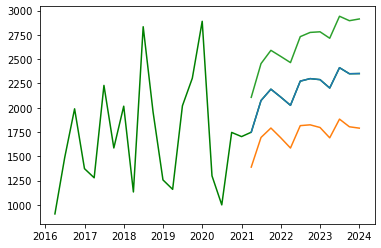

In [87]:
val = starts['multi_start']['1984':].values
variables = ['wti','Alberta_Unemployment rate','Alberta_Real 5-year mortgage rate']

exog = exog_var[variables][:'2020'].values
exog_fcast = exog_var[variables][160-12:160]

model = SARIMAX(val,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.5)
fcast_res.index= pd.date_range(start='2021',periods=12,freq='q')

history = starts['multi_start']['2016':]
history=history.append(fcast_res['mean'])
history.index = pd.date_range(start='2016',end='2024',freq='q')

his_multi = history
f_multi= fcast_res[['mean','mean_ci_lower','mean_ci_upper']]

plt.plot(history,color='green')
plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [229]:
fcast_res.to_csv("multi_fcast_1.csv")

In [204]:
his_total = his_sfd + his_multi
f_total = f_sfd+f_multi

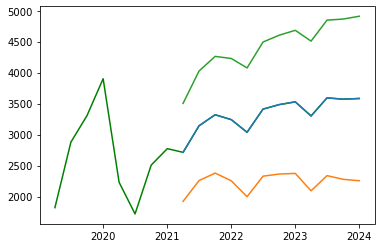

In [206]:

plt.plot(his_total,color='green')
plt.plot(f_total[['mean','mean_ci_lower','mean_ci_upper']]['2018':])

<AxesSubplot:xlabel='_date_'>

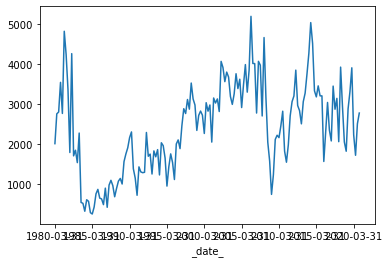

In [130]:
starts['total_start'].plot()

C:\Users\Maln\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


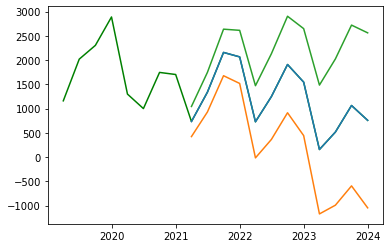

In [68]:
val = starts['multi_start']['1984':].values
variables = ['Alberta_Share of population aged 25-34','Alberta_Unemployment rate','Alberta_Real 5-year mortgage rate','sales']

exog = exog_var[variables][:'2020'].values
exog_fcast = exog_var[variables][160-12:160]

model = SARIMAX(val,order=(1,1,2), seasonal_order=(1,1,1,4),exog=exog)
model_fit=model.fit()
f_cast = model_fit.get_forecast(12,exog=exog_fcast)
fcast_res = f_cast.summary_frame(alpha = 0.6)
fcast_res.index= pd.date_range(start='2021',periods=12,freq='q')

history = starts['multi_start']['2019':]
history=history.append(fcast_res['mean'])
history.index = pd.date_range(start='2019',end='2024',freq='q')

his_multi = history
f_multi= fcast_res[['mean','mean_ci_lower','mean_ci_upper']]

plt.plot(history,color='green')
plt.plot(fcast_res[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [69]:
fcast_res.to_csv("multi_fcast_2.csv")

In [218]:
fcast_res['mean']['2021'].sum()

6067.9569506349035

In [ ]:
multi_starts

In [131]:
exog_var

,morg_rate,wti,Alberta_Real GDP,Alberta_Real household disp. income,Alberta_CPI,Alberta_Unemployment rate,Alberta_Number of households,Alberta_Share of population aged 25-34,Alberta_Real 5-year mortgage rate,sales,avg_price
1984Q1,12.630000,30.198670,123554.787000,43487.392479,0.593435,10.900000,8.036833e+05,0.202737,9.197292,2457.000000,11.401111
1984Q2,14.100000,30.368330,126137.482000,44638.104602,0.595181,11.600000,8.052995e+05,0.202876,12.055714,2323.000000,11.408542
1984Q3,14.466670,29.104330,125411.117000,44106.463796,0.600481,11.733333,8.067957e+05,0.202639,11.631155,2211.000000,11.387045
1984Q4,13.236670,27.430670,129204.614000,44773.150681,0.603223,11.400000,8.083714e+05,0.203535,10.734994,2190.000000,11.272979
1985Q1,12.813330,27.050000,135372.716000,46578.003995,0.608993,10.466667,8.102094e+05,0.204120,10.332823,3212.000000,11.273754
...,...,...,...,...,...,...,...,...,...,...,...
2022Q4,3.643348,53.199447,338112.201822,128427.244475,1.378260,10.256655,1.748555e+06,0.146693,2.430376,6120.240560,13.076814
2023Q1,3.703923,56.015266,344952.995750,129279.509961,1.384873,9.989406,1.757159e+06,0.146431,1.487604,6091.803185,13.083304
2023Q2,3.769940,57.525450,351148.261023,129880.222052,1.394002,9.810232,1.766287e+06,0.146224,0.351555,8203.638505,13.088909
2023Q3,3.836403,54.093129,357387.467980,130535.732965,1.404863,9.549354,1.775714e+06,0.146002,-0.699390,7737.722431,13.104197


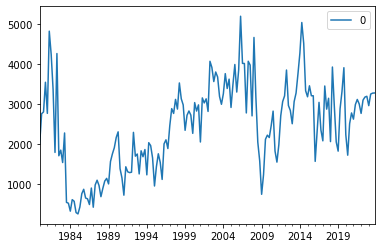

In [159]:
total_fcast = pd.DataFrame(starts['total_start'].append(f_total['mean']))
total_fcast.index = pd.period_range(start='1980',end='2023-12',freq='q')
total_fcast.plot()
plt.plot(f_total[['mean','mean_ci_lower','mean_ci_upper']]['2019':])

In [155]:
starts['total_start'].append(f_total['mean']).index = pd.

1980Q1                 2011.000000
1980Q2                 2754.000000
1980Q3                 2800.000000
1980Q4                 3539.000000
1981Q1                 2764.000000
                          ...     
2022-12-31 00:00:00    3189.350002
2023-03-31 00:00:00    2956.134561
2023-06-30 00:00:00    3244.634387
2023-09-30 00:00:00    3268.315458
2023-12-31 00:00:00    3272.036475
Length: 176, dtype: float64

In [147]:
f_total[['mean','mean_ci_lower','mean_ci_upper']]

y,mean,mean_ci_lower,mean_ci_upper
2021-03-31,2619.749238,2009.246221,3230.252254
2021-06-30,2982.572371,2269.012072,3696.132671
2021-09-30,3110.478100,2341.361390,3879.594809
2021-12-31,2998.995173,2191.402378,3806.587969
2022-03-31,2762.914572,1916.221299,3609.607845
2022-06-30,3094.139958,2214.436729,3973.843186
2022-09-30,3169.976969,2262.852475,4077.101463
2022-12-31,3189.350002,2258.004912,4120.695092
2023-03-31,2956.134561,1985.227723,3927.041400
2023-06-30,3244.634387,2237.092068,4252.176706


In [174]:
f_total['mean']['2021'].sum()

11711.79488194732

In [180]:
starts['total_start']['2019'].sum()

11909.0

In [185]:
his_sfd['2021'].sum()

3865.745430646604

In [186]:
588*4

2352

In [191]:
his_multi['2021'].sum()

8092.606368568804

In [192]:
his_multi

2019-03-31    1160.000000
2019-06-30    2020.000000
2019-09-30    2304.000000
2019-12-31    2890.000000
2020-03-31    1299.000000
2020-06-30    1000.000000
2020-09-30    1746.000000
2020-12-31    1703.000000
2021-03-31    1729.933201
2021-06-30    2069.666910
2021-09-30    2195.868363
2021-12-31    2097.137896
2022-03-31    1916.360236
2022-06-30    2213.048892
2022-09-30    2294.542094
2022-12-31    2247.086630
2023-03-31    2094.196753
2023-06-30    2360.770715
2023-09-30    2365.265837
2023-12-31    2336.832643
Freq: Q-DEC, dtype: float64

In [193]:
nat_exog

,morg_rate,wti
1980Q1,13.816670,35.833330
1980Q2,14.616670,39.500000
1980Q3,13.676670,37.833330
1980Q4,15.156670,36.333330
1981Q1,15.396670,38.000000
...,...,...
2022Q4,3.643348,53.199447
2023Q1,3.703923,56.015266
2023Q2,3.769940,57.525450
2023Q3,3.836403,54.093129
